In [1]:
# Script only for checking diagnostics (ipm histograms, time tool ampl and fltpos histograms, adu histogram, ePix100 ROI check)

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time

from pathlib import Path
from scipy.ndimage import rotate

import XSpect.XSpect_Diagnostics as dt
import psana as ps

print('-----------------')
print('Modules imported!')
print('-----------------')

-----------------
Modules imported!
-----------------


In [2]:
run = 31
exp = 'xcsl1049023'
keys=['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_2/ROI_0_area'] 
names=['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']

d = dt.diagnostics(run, exp, keys, names)


Run 31 imported


In [11]:
cols=np.array(d.h5['epix_2/var_droplet_sparse/col'])
data=np.array(d.h5['epix_2/var_droplet_sparse/data'])
rows=np.array(d.h5['epix_2/var_droplet_sparse/row'])
npix=np.array(d.h5['epix_2/var_droplet_sparse/npix'])
tile=np.array(d.h5['epix_2/var_droplet_sparse/tile'])

print(cols.shape)
print(data.shape)
print(rows.shape)
print(npix.shape)
print(tile.shape)

(13172486,)
(13172486,)
(13172486,)
(13172486,)
(13172486,)


In [12]:
## trying to reconstruct entire detector images before ROI

# start = time.time()

# rows_indx, cols_indx = rows - 1, cols - 1
# rows_indx, cols_indx = rows_indx.astype(int), cols_indx.astype(int)

# data_reconstructed = np.zeros((d.h5['epix_2']['droplet_nDroplets'][:].shape[0],702,766))

# start_indx = 0
# for i, ndrops in enumerate(d.h5['epix_2']['droplet_nDroplets'][:]):   
#     if i == 0:
#         indices_per_shot = np.arange(ndrops)

#     else:
#         indices_per_shot = np.arange(start_indx, start_indx + ndrops, 1)

#     for j in indices_per_shot:
#         data_reconstructed[i, rows_indx[j], cols_indx[j]] = data[j]
#     # print(i)

#     if ndrops > 0:
#         # print(indices_per_shot[-1])
#         start_indx = indices_per_shot[-1]+1

# end = time.time()
# print(end - start)

In [13]:
# start = time.time()

# ROIs = [ [85, 100], [220, 235] ]
# # print(len(ROIs))

# ROI_dict = {}

# for i, ROI in enumerate(ROIs):

#     ROIstr = 'ROI%i' % i
#     ROI_len = ROI[1] - ROI[0]
#     ROI_dict[ROIstr] = data_reconstructed[:,:,ROI[0]:ROI[1]]
#     # print(ROI[0])
#     # print(ROI[1])

# end = time.time()
# print(end - start)

In [16]:
a = np.array([1,2,3,4,5])

print(a[0:4])

[1 2 3 4]


In [36]:
nDroplets = d.h5['epix_2']['droplet_nDroplets'][:]

print(nDroplets.shape)
print(np.nansum(nDroplets[0:1000]))
print(np.nansum(nDroplets[0:2000]))

print(np.nansum(nDroplets))
print(np.nansum(nDroplets[0:None]))

start_shot = 0
end_shot = None

indx_start1 = np.nansum(nDroplets[0:start_shot])
indx_end1 = np.nansum(nDroplets[0:end_shot])


print(indx_start1)
print(indx_end1)
print(cols[0:indx_start1].shape)
print(np.nansum(nDroplets[start_shot:end_shot]))
print(cols[indx_start1:indx_end1].shape)

(36821,)
363025
721136
13172486
13172486
0
13172486
(0,)
13172486
(13172486,)


In [14]:
## recount nDroplets that fall w/in ROI and then directly generate ROI matrices

start = time.time()

rows_indx, cols_indx = rows - 1, cols - 1
rows_indx, cols_indx = rows_indx.astype(int), cols_indx.astype(int)

ROIs = [ [85, 100], [220, 235] ]

ROI_dict = {}

for i, ROI in enumerate(ROIs):

    ROIstr = 'ROI%i' % i
    ROI_len = ROI[1] - ROI[0]
    ROI_dict[ROIstr] = np.zeros((d.h5['epix_2']['droplet_nDroplets'][:].shape[0], 702, ROI_len))

    ndrops_ROI = np.zeros_like(d.h5['epix_2']['droplet_nDroplets'][:])

    ROImask = (cols_indx >= ROI[0]) & (cols_indx < ROI[1])
    print('Sum ROImask')
    print(np.sum(ROImask))
    rows_indx_ROI = rows_indx[ROImask]
    cols_indx_ROI = cols_indx[ROImask]
    data_ROI = data[ROImask]

    start_indx = 0
    for i, ndrops in enumerate(d.h5['epix_2']['droplet_nDroplets'][:]):   
        if i == 0:
            indices_per_shot = np.arange(ndrops)

        else:
            indices_per_shot = np.arange(start_indx, start_indx + ndrops, 1)

        ndrops_ROI[i] = np.sum(ROImask[start_indx:(start_indx + ndrops)])

        if ndrops > 0:
            start_indx = indices_per_shot[-1]+1

    print('Sum ndrops_ROI')
    print(np.sum(ndrops_ROI))
    start_indx = 0
    for i, ndrops in enumerate(ndrops_ROI):   
        if i == 0:
            indices_per_shot = np.arange(ndrops)
    
        else:
            indices_per_shot = np.arange(start_indx, start_indx + ndrops, 1)
    
        for j in indices_per_shot:
            ROI_dict[ROIstr][i, rows_indx_ROI[j], (cols_indx_ROI[j] - ROI[0])] = data_ROI[j]
        # print(i)
    
        if ndrops > 0:
            # print(indices_per_shot[-1])
            start_indx = indices_per_shot[-1]+1

end = time.time()
print(end - start)

Sum ROImask
555572
Sum ndrops_ROI
555572
Sum ROImask
542373
Sum ndrops_ROI
542373
2.7033262252807617


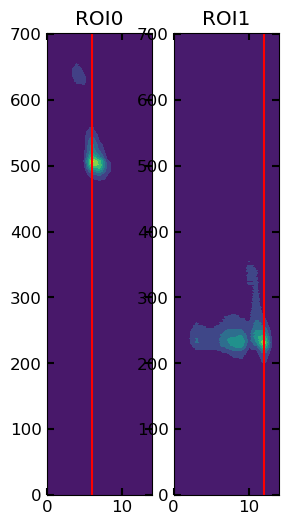

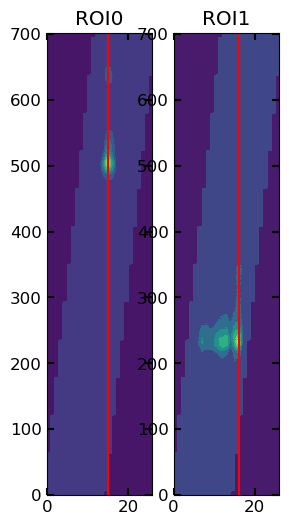

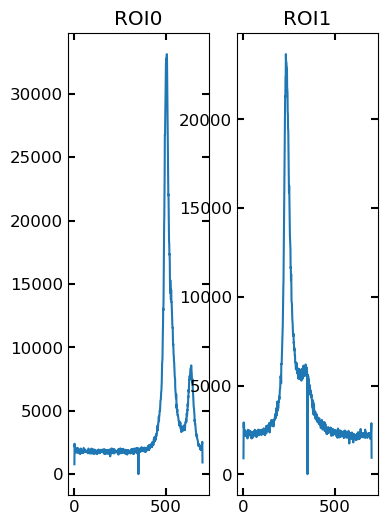

In [15]:
fig, ax = plt.subplots(figsize = (len(ROI_dict)*1.5,6), nrows = 1, ncols = len(ROI_dict))


for i, ROI in enumerate(ROI_dict):
    ROI_image = np.nansum(ROI_dict[ROI], axis = 0)
    ax[i].contourf(ROI_image)
    peak_indx = np.unravel_index(np.argmax(ROI_image, axis = None), ROI_image.shape)
    ax[i].axvline(peak_indx[1], color = 'r', linewidth = 1.5)
    ax[i].set_title(ROI)


fig, ax = plt.subplots(figsize = (len(ROI_dict)*1.5,6), nrows = 1, ncols = len(ROI_dict))

angle = 1

for i, ROI in enumerate(ROI_dict):
    ROI_image = np.nansum(ROI_dict[ROI], axis = 0)
    ROI_image_rot = rotate(ROI_image, angle, reshape = True)
    ax[i].contourf(ROI_image_rot)
    peak_indx = np.unravel_index(np.argmax(ROI_image_rot, axis = None), ROI_image_rot.shape)
    ax[i].axvline(peak_indx[1], color = 'r', linewidth = 1.5)
    ax[i].set_title(ROI)

fig, ax = plt.subplots(figsize = (len(ROI_dict)*2,6), nrows = 1, ncols = len(ROI_dict))
ROI_proj_dict = {}
for i, ROI in enumerate(ROI_dict):
    ROI_image = np.nansum(ROI_dict[ROI], axis = 0)
    ROI_image_rot = rotate(ROI_image, angle, reshape = True)
    ROI_proj_rot = np.nansum(ROI_image_rot, axis = 1)
    ROI_proj_dict[ROI] = ROI_proj_rot

    ax[i].plot(ROI_proj_rot)
    ax[i].set_title(ROI)

(300.0, 400.0)

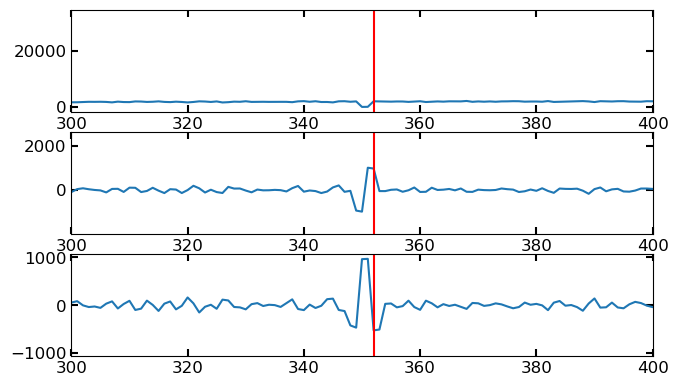

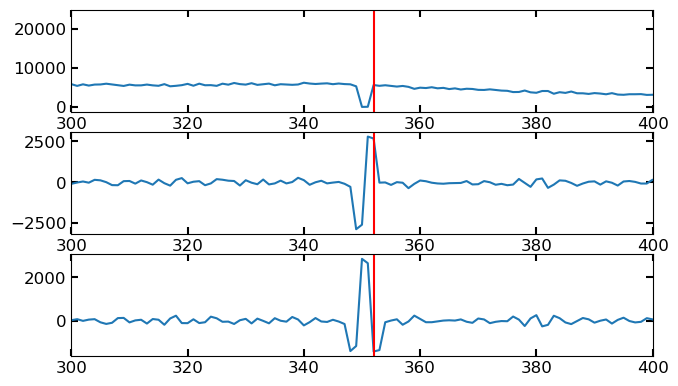

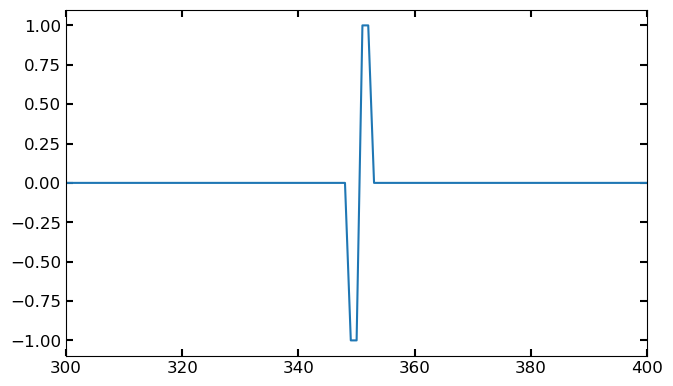

In [109]:
fig, ax = plt.subplots(nrows = 3, ncols = 1)

data2plot = ROI_proj_dict['ROI0'][:] 
ax[0].plot(data2plot)
grad1 = np.gradient(data2plot)
ax[1].plot(grad1)
grad2 = np.gradient(grad1)
ax[2].plot(grad2)

ax[0].set_xlim([300, 400])
ax[1].set_xlim([300, 400])
ax[2].set_xlim([300, 400])

pixno = 352
ax[0].axvline(pixno, color = 'r')
ax[1].axvline(pixno, color = 'r')
ax[2].axvline(pixno, color = 'r')

# maxdiscont_indx = np.argmax(np.abs(np.gradient(ROI_proj_dict['ROI0'][:])))
# ax[1].axvspan(maxdiscont_indx-2, maxdiscont_indx+2, color = 'r', alpha = 0.4)

fig, ax = plt.subplots(nrows = 3, ncols = 1)

data2plot = ROI_proj_dict['ROI1'][:] 
ax[0].plot(data2plot)
grad1 = np.gradient(data2plot)
ax[1].plot(grad1)
grad2 = np.gradient(grad1)
ax[2].plot(grad2)

ax[0].set_xlim([300, 400])
ax[1].set_xlim([300, 400])
ax[2].set_xlim([300, 400])
ax[0].axvline(pixno, color = 'r')
ax[1].axvline(pixno, color = 'r')
ax[2].axvline(pixno, color = 'r')

# maxdiscont_indx = np.argmax(np.abs(np.gradient(ROI_proj_dict['ROI1'][:])))
# ax[1].axvspan(maxdiscont_indx-2, maxdiscont_indx+2, color = 'r', alpha = 0.4)

filtfxn1 = np.zeros_like(ROI_proj_dict['ROI0'])


filtfxn1[np.round(len(filtfxn1)/2 - 2).astype(int)] = -1
filtfxn1[np.round(len(filtfxn1)/2 - 1).astype(int)] = -1
filtfxn1[np.round(len(filtfxn1)/2 + 0).astype(int)] = 1
filtfxn1[np.round(len(filtfxn1)/2 + 1).astype(int)] = 1

plt.figure()
plt.plot(filtfxn1)
plt.xlim([300, 400])

351
351


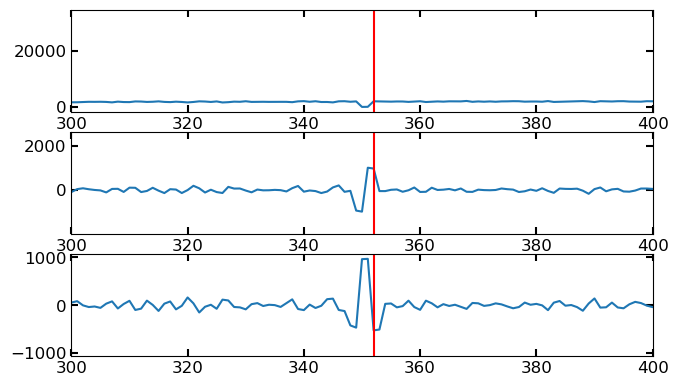

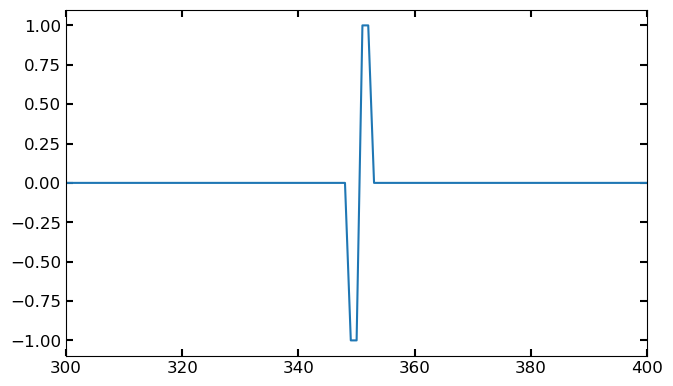

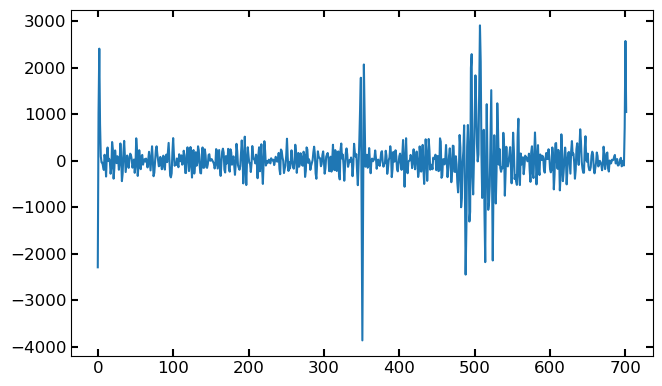

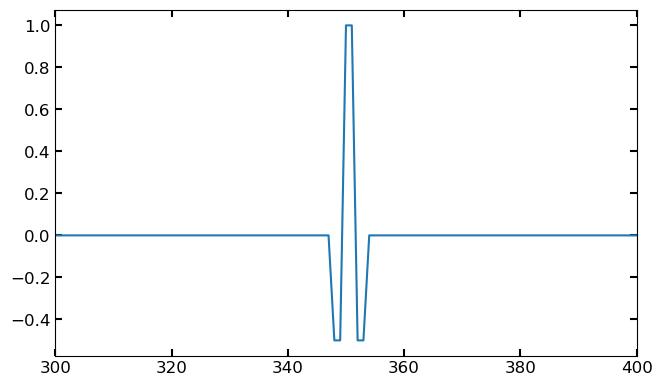

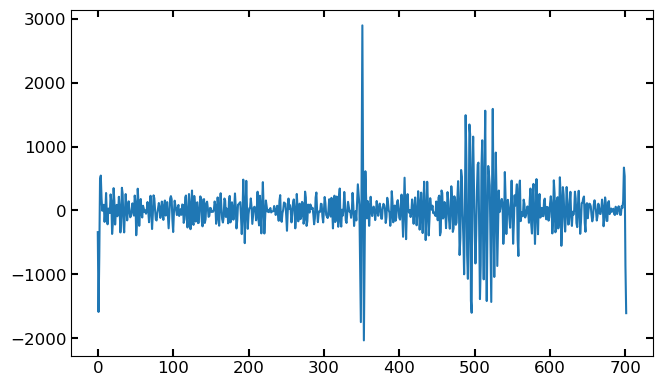

In [120]:
fig, ax = plt.subplots(nrows = 3, ncols = 1)

data2plot = ROI_proj_dict['ROI0'][:] 
ax[0].plot(data2plot)
grad1 = np.gradient(data2plot)
ax[1].plot(grad1)
grad2 = np.gradient(grad1)
ax[2].plot(grad2)

ax[0].set_xlim([300, 400])
ax[1].set_xlim([300, 400])
ax[2].set_xlim([300, 400])

pixno = 352
ax[0].axvline(pixno, color = 'r')
ax[1].axvline(pixno, color = 'r')
ax[2].axvline(pixno, color = 'r')

filtfxn1 = np.zeros_like(ROI_proj_dict['ROI0'])


filtfxn1[np.round(len(filtfxn1)/2 - 2).astype(int)] = -1
filtfxn1[np.round(len(filtfxn1)/2 - 1).astype(int)] = -1
filtfxn1[np.round(len(filtfxn1)/2 + 0).astype(int)] = 1
filtfxn1[np.round(len(filtfxn1)/2 + 1).astype(int)] = 1

plt.figure()
plt.plot(filtfxn1)
plt.xlim([300, 400])

dead_pix_conv = np.convolve(grad1, filtfxn1, mode = 'same')

plt.figure()
plt.plot(dead_pix_conv)

filtfxn2 = np.zeros_like(ROI_proj_dict['ROI0'])


filtfxn2[np.round(len(filtfxn2)/2 - 3).astype(int)] = -0.5
filtfxn2[np.round(len(filtfxn2)/2 - 2).astype(int)] = -0.5
filtfxn2[np.round(len(filtfxn2)/2 - 1).astype(int)] = 1
filtfxn2[np.round(len(filtfxn2)/2 + 0).astype(int)] = 1
filtfxn2[np.round(len(filtfxn2)/2 + 1).astype(int)] = -0.5
filtfxn2[np.round(len(filtfxn2)/2 + 2).astype(int)] = -0.5

plt.figure()
plt.plot(filtfxn2)
plt.xlim([300, 400])

dead_pix_conv2 = np.convolve(grad2, filtfxn2, mode = 'same')

plt.figure()
plt.plot(dead_pix_conv2)

print(np.argmax(np.abs(dead_pix_conv)))
print(np.argmax(np.abs(dead_pix_conv2)))

In [35]:
start = time.time()

ROIs = [ [85, 100], [225, 240] ]
print(len(ROIs))

rows_indx, cols_indx = rows - 1, cols - 1
rows_indx, cols_indx = rows_indx.astype(int), cols_indx.astype(int)

ROI_dict = {}

for i, ROI in enumerate(ROIs):

    ROIstr = 'ROI%i' % i
    ROI_len = ROI[1] - ROI[0]
    ROI_dict[ROIstr] = np.zeros((d.h5['epix_2']['droplet_nDroplets'][:].shape[0], 702, ROI_len))
    print(ROI[0])
    print(ROI[1])

    start_indx = 0
    for i, ndrops in enumerate(d.h5['epix_2']['droplet_nDroplets'][:]):   
        if i == 0:
            indices_per_shot = np.arange(ndrops)
    
        else:
            indices_per_shot = np.arange(start_indx, start_indx + ndrops, 1)
    
        for j in indices_per_shot:
            if cols_indx[j] > ROI[0] & cols_indx[j] < ROI[1]:
                ROI_dict[ROIstr][i, rows_indx[j], cols_indx[j]] = data[j]

        if ndrops > 0:
        # print(indices_per_shot[-1])
        start_indx = indices_per_shot[-1]+1

    # ROImask = (cols_indx > ROI[0]) & (cols_indx < ROI[1])
    # cols_ROI = cols_indx[ROImask]
    # rows_ROI = rows_indx[ROImask]
    # data_ROI = data[ROImask]

    # ROI_dict[ROIstr][




2
85
100
[False False False ... False False False]
225
240
[False False False ... False False False]


In [ ]:
a = np.nansum(data_reconstructed, axis = 0)

In [60]:
ndrops = d.h5['epix_2']['droplet_nDroplets'][:]

np.where(ndrops == 0)

(array([   38,   175,   312,   449,   586,   723,   860,   997,  1134,
         1271,  1408,  1545,  1682,  1819,  1956,  2093,  2230,  2367,
         2504,  2641,  2778,  2915,  3052,  3189,  3326,  3463,  3600,
         3737,  3874,  4011,  4148,  4285,  4422,  4559,  4696,  4833,
         4970,  5107,  5244,  5381,  5518,  5655,  5792,  5929,  6066,
         6203,  6340,  6477,  6614,  6751,  6888,  7025,  7162,  7299,
         7436,  7573,  7710,  7847,  7984,  8121,  8258,  8395,  8532,
         8669,  8806,  8943,  9080,  9217,  9354,  9491,  9628,  9765,
         9902, 10039, 10176, 10313, 10450, 10587, 10724, 10861, 10998,
        11135, 11272, 11409, 11546, 11683, 11820, 11957, 12094, 12231,
        12368, 12505, 12642, 12779, 12916, 13053, 13190, 13327, 13464,
        13601, 13738, 13875, 14012, 14149, 14286, 14423, 14560, 14697,
        14834, 14971, 15108, 15245, 15382, 15519, 15656, 15793, 15930,
        16067, 16204, 16341, 16478, 16615, 16752, 16889, 17026, 17163,
      

In [49]:
rows_indx

array([  0.,   0.,   6., ..., 687., 691., 692.])

In [26]:
data_reconstructed.shape

(36821, 701, 765)

<BarContainer object of 250 artists>

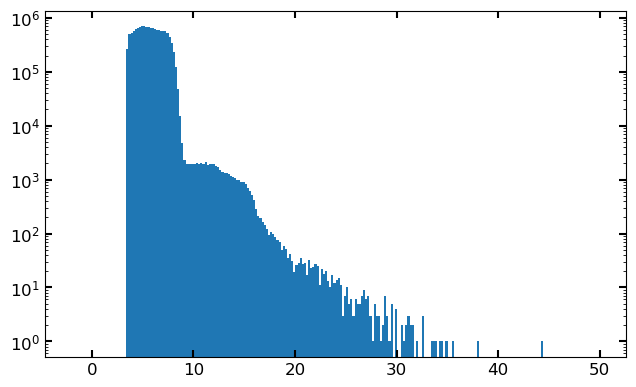

In [7]:
num_bins = 250
hist_range = (-2, 50)  # Adjust this range according to expected pixel values
hist_bins = np.linspace(hist_range[0], hist_range[1], num_bins + 1)
hist_values = np.zeros(num_bins)
hist_values = np.histogram(data, bins=hist_bins)[0]
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
plt.bar(bin_centers, hist_values, align='center', width=hist_bins[1] - hist_bins[0],log=True)

In [8]:
data

array([4.44310331, 5.27738523, 4.66839218, ..., 6.26256704, 6.93511343,
       4.51940441])

In [9]:
print(np.min(cols))
print(np.min(rows))
print(np.max(cols))
print(np.max(rows))

1.0
1.0
766.0
702.0


In [10]:
x_edges=np.arange(1,766,1)
y_edges=np.arange(1,702,1)
H,xedges,yedges=np.histogram2d(cols,rows,bins=(x_edges,y_edges))
X,Y=np.meshgrid(xedges,yedges)

# ROI0_ll, ROI0_ul = 50, 120
# ROI1_ll, ROI1,ul = 205, 250

# plt.pcolormesh(X,Y,H.T)
# plt.axvline(ROI_ll, color = 'r', linewidth = 1.5)

## this is just a histogram of the cols/rows data for the droplets, i.e. which pixel a droplet
## is indexed to be over all shots in the data

In [11]:
rows_idx, cols_idx = rows - 1, cols - 1
print(np.min(cols_idx))
print(np.min(rows_idx))
print(np.max(cols_idx))
print(np.max(rows_idx))

0.0
0.0
765.0
701.0


In [66]:
print(X.shape)
print(Y.shape)
print(x_edges.shape)
print(y_edges.shape)
print(xedges.shape)
print(yedges.shape)
print(H.T.shape)

(701, 765)
(701, 765)
(765,)
(701,)
(765,)
(701,)
(700, 764)


In [65]:
xedges

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

TypeError: Dimensions of C (700, 15) are incompatible with X (15) and/or Y (701); see help(pcolormesh)

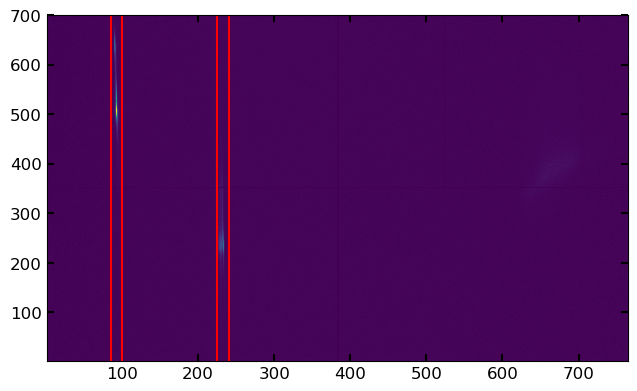

In [63]:
ROI0_ll, ROI0_ul = 85, 100
ROI1_ll, ROI1_ul = 225, 240

plt.pcolormesh(X,Y,H.T)
plt.axvline(ROI0_ll, color = 'r', linewidth = 1.5)
plt.axvline(ROI0_ul, color = 'r', linewidth = 1.5)
plt.axvline(ROI1_ll, color = 'r', linewidth = 1.5)
plt.axvline(ROI1_ul, color = 'r', linewidth = 1.5)

ROI0_ll_idx, ROI0_ul_idx = np.where(X[0,:] == ROI0_ll)[0][0], np.where(X[0,:] == ROI0_ul)[0][0]

plt.pcolormesh(X[:,ROI0_ll_idx:ROI0_ul_idx], Y[:,ROI0_ll_idx:ROI0_ul_idx], H.T[:,ROI0_ll_idx:ROI0_ul_idx], shading = 'nearest')

/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid va

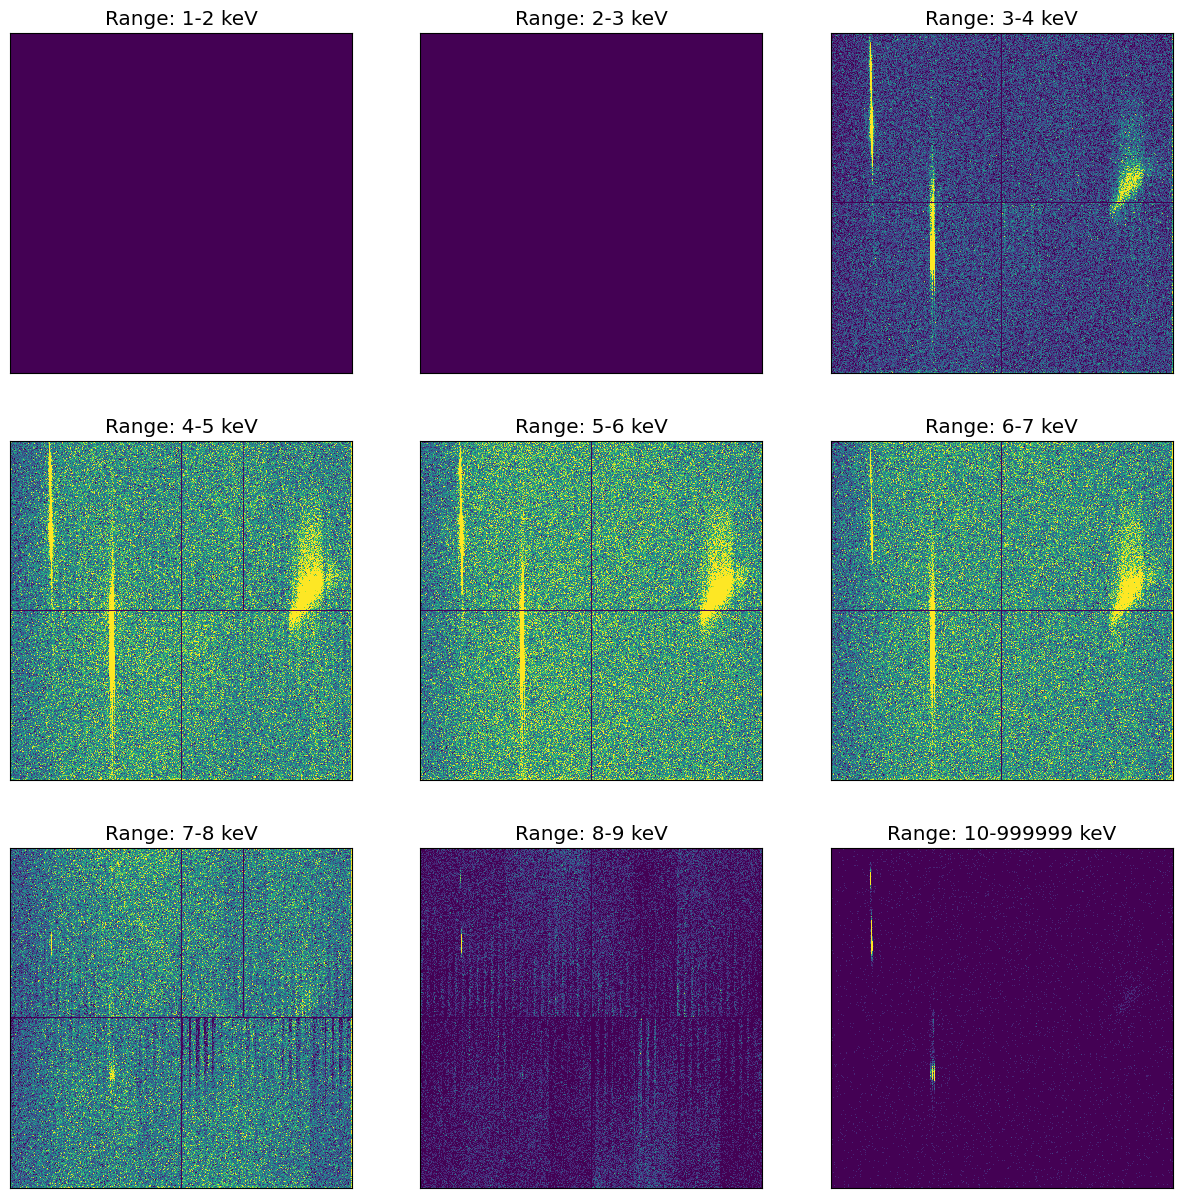

In [18]:
def find_lims(data, f):
    """Return low and high limits based on a factor, ignoring zero values."""
    non_zero_data = data[data != 0]  # Filter out zeros
    x_bar = np.mean(non_zero_data)
    sig_x = np.std(non_zero_data)
    low_lim = x_bar - f * sig_x
    high_lim = x_bar + f * sig_x
    return low_lim, high_lim
import pandas as pd
df=pd.DataFrame()
df['col']=cols
df['row']=rows
df['data']=data

scale = 1
xedges = np.linspace(1, 766, int(766/scale))
yedges = np.linspace(1, 702, int(702/scale))
df_hits=df
data_ranges = [(1,2),(2,3),(3,4), (4,5), (5,6), (6,7), (7,8), (8,9),(10,999999)]
num_cols = 3
num_rows = int(np.ceil(len(data_ranges) / num_cols))  # Ensure proper layout

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, data_range in enumerate(data_ranges):
    subset_filt_data = df_hits[(df_hits['data'] >= data_range[0]) & (df_hits['data'] < data_range[1])]
    H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))

    X, Y = np.meshgrid(xedges, yedges)
    f = 0.5
    low_lim, upper_lim = find_lims(H, f)
    
    ax = axes[i // num_cols, i % num_cols]  # Select subplot

    im = ax.pcolormesh(X, Y, H.T, vmin=low_lim, vmax=upper_lim)
    im = ax.pcolormesh(X, Y, H.T,vmin=0, vmax=10)

    ax.set_title(f'Range: {data_range[0]}-{data_range[1]} keV')
    ax.set_xticks([])
    ax.set_yticks([])
    # cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Counts")

In [5]:
d.datadict

{'ccm': 'epics/ccm_E',
 'time_tool_correction': 'tt/ttCorr',
 'lxt_ttc': 'epics/lxt_ttc',
 'encoder': 'enc/lasDelay',
 'ipm': 'ipm4/sum',
 'time_tool_ampl': 'tt/AMPL',
 'epix': 'epix_2/ROI_0_area'}

In [ ]:
nshots = 1000
thresholds = [3]

d.adu_histogram(nshots, thresholds)

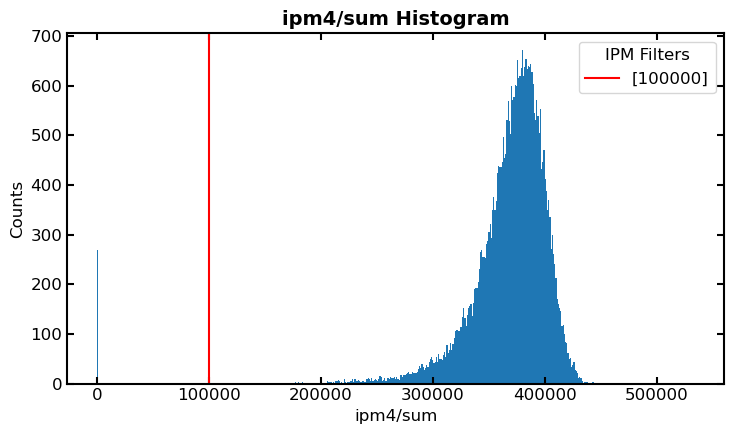

In [6]:
ipm_thres = [100000]

d.ipm_histogram(ipm_thres)

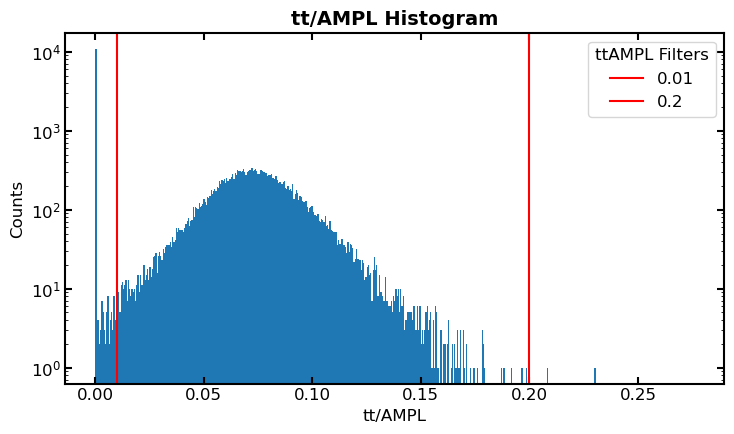

In [7]:
tt_thres = [0.01, 0.2]

d.ttAMPL_histogram(tt_thres)

In [11]:
d.h5['epix_2']['ROI_0_area']

<HDF5 dataset "ROI_0_area": shape (36821, 699, 768), type "<f4">

In [14]:
d.h5.keys()

<KeysViewHDF5 ['Sums', 'UserDataCfg', 'damage', 'diodeGon', 'ebeam', 'enc', 'epics', 'epicsOnce', 'epix10k2M', 'epix_2', 'epix_2_env', 'event_time', 'evr', 'fiducials', 'gas_detector', 'ipm4', 'ipm5', 'ipm_hx2', 'lightStatus', 'phase_cav', 'scan', 'tt']>

In [16]:
d.h5['Sums']['epix_2_calib']

<HDF5 dataset "epix_2_calib": shape (704, 768), type "<f4">

AttributeError: 'XAxis' object has no attribute 'set_linewidth'

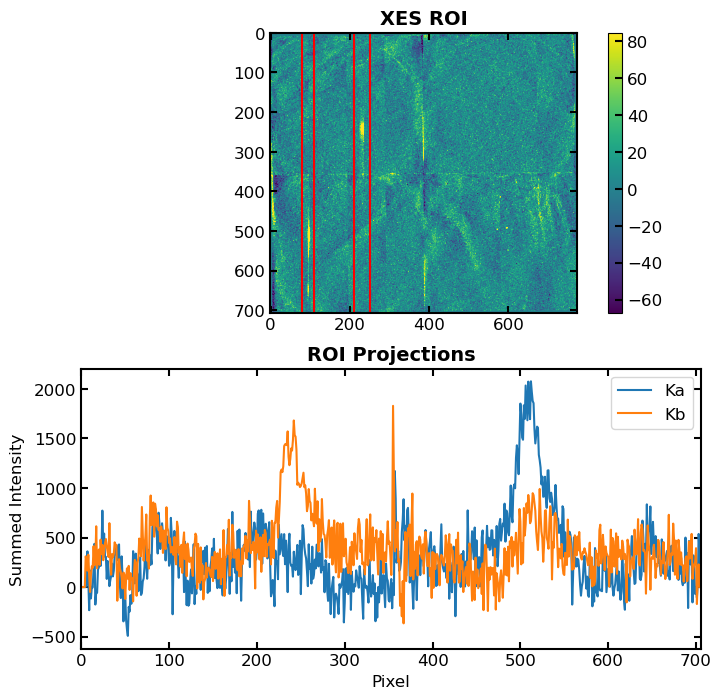

In [8]:
nshots = 1000
ka_roi = [80, 110]
kb_roi = [210, 250]
#fe_kb_roi = [40,60]

d.xes_ROI(nshots, ka_limits = ka_roi, kb_limits = kb_roi, angle = 0.5)


In [ ]:
#nshots = 1000
# ka_roi = [120, 140]
#kb_roi = [140, 155]
#fe_kb_roi = [40,60]

#d.xes_ROI(nshots, kb_limits = kb_roi)


AttributeError: 'XAxis' object has no attribute 'set_linewidth'

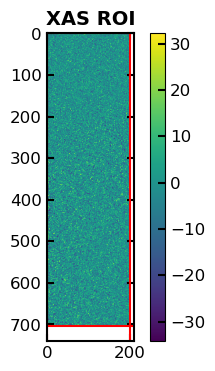

In [4]:
#nshots = 1000
#h_lims = [40, 160]
#v_lims = [150, 400]
nshots = 1000
h_lims = [0, 200]
v_lims = [0, 705]
d.xas_ROI(nshots, horiz_limits = h_lims, vert_limits = v_lims)